We implement a "linear scan" based algorithm for the inference of first-order linear recurrences:
$$
    x_t = a_{t} x_{t-1} + u_t
$$

The algorithm is implemented in C++ and is exposed to Python via torch.ops.


This time the package includes two kernels:
- `fused_linear_scan`: a simple native torch ops kernel
- `fused_linear_scan2`: we used a simple trick to make it faster, 
    i.e. using explicit pointer arithmetic rather than torch indexing.

The optimized kernel is more than one order of magnitude faster while using the same amount of memory.



In [12]:
from pathlib import Path
from typing import Tuple, Union
import fused_linear_scan
import os
import torch
import torch.nn as nn
from torch.export import export, ExportedProgram
from executorch.exir import EdgeProgramManager, to_edge
from executorch.exir.backend.backend_api import LoweredBackendModule
from executorch.backends.xnnpack.utils.configs import get_xnnpack_edge_compile_config
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.devtools import Inspector
from profiler import Profiler, ProfilingResults, extract_stats

class LinearScanModule(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x0, a, u):
        return torch.ops.linear_scan.fused_linear_scan(x0, a, u)

# Example inputs
B, C, N = 1, 2048, 1024
example_args = (
    torch.randn(B, C, dtype=torch.float32),
    torch.randn(B, C, N, dtype=torch.float32),
    torch.randn(B, C, N, dtype=torch.float32)
)

# Export and lower the module
module = LinearScanModule()
aten_dialect_program: ExportedProgram = export(module, example_args)

edge_config = get_xnnpack_edge_compile_config()
edge_program: EdgeProgramManager = to_edge(aten_dialect_program, compile_config=edge_config)

# Lower the module
edge_manager_to_backend: LoweredBackendModule = edge_program.to_backend(XnnpackPartitioner())
et_program = edge_manager_to_backend.to_executorch()

# Serialize and save
save_path = "linear_scan_delegate.pte"
with open(save_path, "wb") as f:
    f.write(et_program.buffer)

# Profile using the local profiler
pte_runner_path = os.environ.get("PTE_RUNNER_PATH", 'runner/macos-arm64/pte_runner')
profiler = LocalPyProfiler(pte_runner_path)
profiling_result = profiler.profile(save_path, example_args, repeats=20)
print(profiling_result)

Unsupported: unsupported operator: linear_scan.fused_linear_scan.default (see https://docs.google.com/document/d/1GgvOe7C8_NVOMLOCwDaYV1mXXyHMXY7ExoewHqooxrs/edit#heading=h.64r4npvq0w0 for how to fix)

from user code:
   File "/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_77205/3995545870.py", line 20, in forward
    return torch.ops.linear_scan.fused_linear_scan(x0, a, u)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


L=2, fused_linear_scan: 0.00 ms, fused_linear_scan2: 0.00 ms, fused_linear_scan: 88.48 MB, fused_linear_scan2: 88.55 MB
L=4, fused_linear_scan: 0.00 ms, fused_linear_scan2: 0.00 ms, fused_linear_scan: 89.02 MB, fused_linear_scan2: 89.30 MB
L=8, fused_linear_scan: 0.01 ms, fused_linear_scan2: 0.01 ms, fused_linear_scan: 89.83 MB, fused_linear_scan2: 89.89 MB
L=16, fused_linear_scan: 0.01 ms, fused_linear_scan2: 0.01 ms, fused_linear_scan: 91.00 MB, fused_linear_scan2: 91.20 MB
L=32, fused_linear_scan: 0.03 ms, fused_linear_scan2: 0.04 ms, fused_linear_scan: 92.98 MB, fused_linear_scan2: 93.56 MB
L=64, fused_linear_scan: 0.08 ms, fused_linear_scan2: 0.09 ms, fused_linear_scan: 96.83 MB, fused_linear_scan2: 97.33 MB
L=128, fused_linear_scan: 0.20 ms, fused_linear_scan2: 0.21 ms, fused_linear_scan: 103.34 MB, fused_linear_scan2: 105.84 MB
L=256, fused_linear_scan: 0.62 ms, fused_linear_scan2: 0.61 ms, fused_linear_scan: 115.89 MB, fused_linear_scan2: 121.89 MB
L=512, fused_linear_scan: 1.3

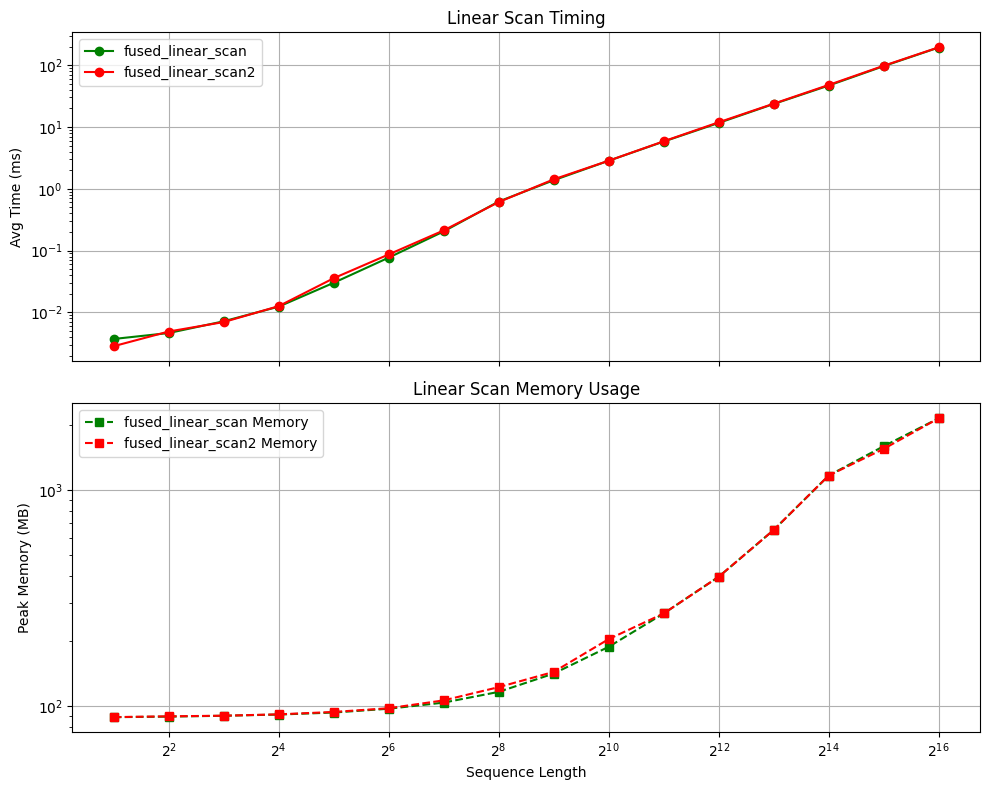

In [ ]:
import torch
import time
import matplotlib.pyplot as plt
from statistics import median
import fused_linear_scan
from memory_profiler import memory_usage

# Native Python implementation of the recurrence:
def native_linear_scan(x0, a, u):
    B, C, N = a.shape
    x = torch.zeros(B, C, N, dtype=a.dtype, device=a.device)
    x[..., 0] = a[..., 0] * x0 + u[..., 0]
    for t in range(1, N):
        x[..., t] = a[..., t] * x[..., t-1] + u[..., t]
    return x

# Quick correctness test with small random tensors.
x0 = torch.randn(1, 32)
a = torch.randn(1, 32, 128)
u = torch.randn(1, 32, 128)
y_custom = torch.ops.linear_scan.fused_linear_scan(x0, a, u)
y_custom2 = torch.ops.linear_scan.fused_linear_scan2(x0, a, u)
y_native = native_linear_scan(x0, a, u)

assert torch.allclose(y_custom, y_native, atol=1e-3)
assert torch.allclose(y_custom2, y_native, atol=1e-3)

# Benchmarking parameters.
sequence_lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
channels = 2048
iters = 20  # Number of iterations per sequence length.

methods = {
    "fused_linear_scan": torch.ops.linear_scan.fused_linear_scan,
    "fused_linear_scan2": torch.ops.linear_scan.fused_linear_scan2,
}

stats = {name: {"times": [], "peak_memory": []} for name in methods}

def measure_peak_memory(func, *args, **kwargs):
    mem_usage = memory_usage((func, args, kwargs), interval=0.001, timeout=None)
    return max(mem_usage)

for L in sequence_lengths:
    # Create random inputs for each sequence length.
    x0 = torch.randn(1, channels)
    a = torch.randn(1, channels, L)
    u = torch.randn(1, channels, L)
    
    # Warm-up runs.
    for name, func in methods.items():
        _ = func(x0, a, u)
    
    # Measure execution time and peak memory usage.
    for name, func in methods.items():
        run_times = []
        mem_peaks = []
        for _ in range(iters):
            start = time.perf_counter()
            _ = func(x0, a, u)
            run_times.append((time.perf_counter() - start) * 1000)
        peak_mem = measure_peak_memory(func, x0, a, u)
        mem_peaks.append(peak_mem)
        stats[name]["times"].append(median(run_times))
        stats[name]["peak_memory"].append(median(mem_peaks))
    
    times_str = ", ".join(f"{name}: {stats[name]['times'][-1]:.2f} ms" for name in methods)
    mem_str = ", ".join(f"{name}: {stats[name]['peak_memory'][-1]:.2f} MB" for name in methods)
    print(f"L={L}, {times_str}, {mem_str}")

# Plotting results.
fig, (ax_time, ax_mem) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax_time.set_xscale('log', base=2)
ax_time.set_yscale('log')
ax_time.plot(sequence_lengths, stats["fused_linear_scan"]["times"], '-o', label="fused_linear_scan", color="green")
ax_time.plot(sequence_lengths, stats["fused_linear_scan2"]["times"], '-o', label="fused_linear_scan2", color="red")
ax_time.set_ylabel("Avg Time (ms)")
ax_time.grid(True)
ax_time.legend(loc="upper left")
ax_time.set_title("Linear Scan Timing")

ax_mem.set_xscale('log', base=2)
ax_mem.set_yscale('log')
ax_mem.plot(sequence_lengths, stats["fused_linear_scan"]["peak_memory"], '--s', label="fused_linear_scan Memory", color="green")
ax_mem.plot(sequence_lengths, stats["fused_linear_scan2"]["peak_memory"], '--s', label="fused_linear_scan2 Memory", color="red")
ax_mem.set_xlabel("Sequence Length")
ax_mem.set_ylabel("Peak Memory (MB)")
ax_mem.grid(True)
ax_mem.legend(loc="upper left")
ax_mem.set_title("Linear Scan Memory Usage")

plt.tight_layout()
plt.show()


In [ ]:
import torch 
import fused_linear_scan
import time
import matplotlib.pyplot as plt
from statistics import median
from memory_profiler import memory_usage

x = torch.randn(1, 32)
a = torch.randn(1, 32, 128)
u = torch.randn(1, 32, 128)
y = torch.ops.linear_scan.fused_linear_scan(x, a, u)
y2 = torch.ops.linear_scan.fused_linear_scan2(x, a, u)

In [ ]:
def native_linear_scan(x0, a, u):
    B, C, N = a.shape
    x = torch.zeros(B, C, N, dtype=a.dtype, device=a.device)
    x[..., 0] = a[..., 0] * x0 + u[..., 0]
    for t in range(1, N):
        x[..., t] = a[..., t] * x[..., t-1] + u[..., t]
    return x

y_native = native_linear_scan(x, a, u)

# Check if the two implementations give the same result
assert torch.allclose(y, y_native, atol=1e-5)
assert torch.allclose(y2, y_native, atol=1e-5)
print("Both implementations give the same result!")


Both implementations give the same result!


In [ ]:
import torch 
import time
import matplotlib.pyplot as plt
from statistics import median
from memory_profiler import memory_usage

# Native Python version for reference
def native_linear_scan(x0, a, u):
    B, C, N = a.shape
    x = torch.zeros(B, C, N, dtype=a.dtype, device=a.device)
    x[..., 0] = a[..., 0] * x0 + u[..., 0]
    for t in range(1, N):
        x[..., t] = a[..., t] * x[..., t-1] + u[..., t]
    return x

# Measure peak memory usage
def measure_peak_memory(func, *args, **kwargs):
    mem_usage = memory_usage((func, args, kwargs), interval=0.001, timeout=None)
    return max(mem_usage)

# Define a range of sequence lengths to test
sequence_lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
channels = 2048
iters = 20  # Number of iterations for median timing and memory profiling

# Include fused_linear_scan3 from examples/linear_scan/ops/linear_scan.cpp
methods = {
    "native_linear_scan": native_linear_scan,
    "fused_linear_scan": torch.ops.linear_scan.fused_linear_scan,
    "fused_linear_scan2": torch.ops.linear_scan.fused_linear_scan2,
}

stats = {name: {"times": [], "peak_memory": []} for name in methods}

for L in sequence_lengths:
    # Create random inputs of length L for each channel
    x0 = torch.randn(1, channels)
    a = torch.randn(1, channels, L)
    u = torch.randn(1, channels, L)

    # Warm-up runs
    for name, func in methods.items():
        _ = func(x0, a, u)

    # Measure timing and peak memory
    for name, func in methods.items():
        run_times = []
        mem_peaks = []
        for _ in range(iters):
            start = time.perf_counter()
            _ = func(x0, a, u)
            run_times.append((time.perf_counter() - start) * 1000)
        peak_mem = measure_peak_memory(func, x0, a, u)
        mem_peaks.append(peak_mem)
        stats[name]["times"].append(median(run_times))
        stats[name]["peak_memory"].append(median(mem_peaks))

    # Print results
    times_str = ", ".join(f"{name}: {stats[name]['times'][-1]:.2f} ms" for name in methods)
    mem_str = ", ".join(f"{name}: {stats[name]['peak_memory'][-1]:.2f} MB" for name in methods)
    print(f"L={L}, {times_str}, {mem_str}")

L=2, native_linear_scan: 0.02 ms, fused_linear_scan: 0.00 ms, fused_linear_scan2: 0.00 ms, native_linear_scan: 212.44 MB, fused_linear_scan: 212.44 MB, fused_linear_scan2: 212.47 MB
L=4, native_linear_scan: 0.03 ms, fused_linear_scan: 0.00 ms, fused_linear_scan2: 0.00 ms, native_linear_scan: 212.62 MB, fused_linear_scan: 212.62 MB, fused_linear_scan2: 212.67 MB
L=8, native_linear_scan: 0.07 ms, fused_linear_scan: 0.01 ms, fused_linear_scan2: 0.01 ms, native_linear_scan: 212.86 MB, fused_linear_scan: 212.92 MB, fused_linear_scan2: 212.98 MB
L=16, native_linear_scan: 0.19 ms, fused_linear_scan: 0.01 ms, fused_linear_scan2: 0.01 ms, native_linear_scan: 213.27 MB, fused_linear_scan: 213.41 MB, fused_linear_scan2: 213.41 MB
L=32, native_linear_scan: 0.40 ms, fused_linear_scan: 0.03 ms, fused_linear_scan2: 0.03 ms, native_linear_scan: 215.02 MB, fused_linear_scan: 215.52 MB, fused_linear_scan2: 215.52 MB
L=64, native_linear_scan: 0.83 ms, fused_linear_scan: 0.07 ms, fused_linear_scan2: 0.09 

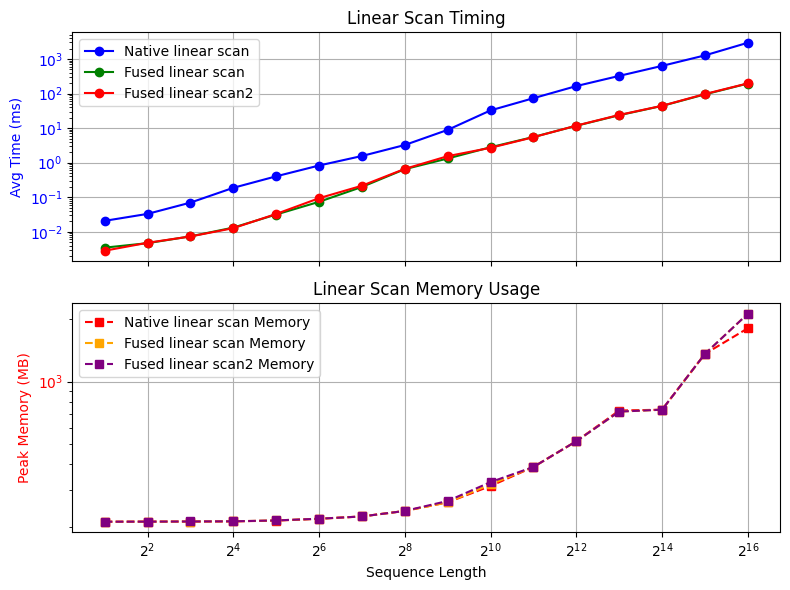

In [ ]:
# Plot the results
fig, (ax_time, ax_mem) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax_time.set_xscale('log', base=2)
ax_time.set_yscale('log')
ax_time.plot(sequence_lengths, stats['native_linear_scan']['times'], '-o', label='Native linear scan', color='blue')
ax_time.plot(sequence_lengths, stats['fused_linear_scan']['times'], '-o', label='Fused linear scan', color='green')
ax_time.plot(sequence_lengths, stats['fused_linear_scan2']['times'], '-o', label='Fused linear scan2', color='red')
ax_time.set_ylabel('Avg Time (ms)', color='blue')
ax_time.tick_params(axis='y', labelcolor='blue')
ax_time.grid(True)
ax_time.legend(loc='upper left')
ax_time.set_title('Linear Scan Timing')

ax_mem.set_xscale('log', base=2)
ax_mem.set_yscale('log')
ax_mem.plot(sequence_lengths, stats['native_linear_scan']['peak_memory'], '--s', label='Native linear scan Memory', color='red')
ax_mem.plot(sequence_lengths, stats['fused_linear_scan']['peak_memory'], '--s', label='Fused linear scan Memory', color='orange')
ax_mem.plot(sequence_lengths, stats['fused_linear_scan2']['peak_memory'], '--s', label='Fused linear scan2 Memory', color='purple')
ax_mem.set_xlabel('Sequence Length')
ax_mem.set_ylabel('Peak Memory (MB)', color='red')
ax_mem.tick_params(axis='y', labelcolor='red')
ax_mem.grid(True)
ax_mem.legend(loc='upper left')
ax_mem.set_title('Linear Scan Memory Usage')

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn

class LinearRecurrence(nn.Module):
    def __init__(self, channels: int):
        """
        channels: Number of input/output channels.
        seq_len: (Optional) Expected sequence length (not strictly required for the model definition).
        """
        super().__init__()
        self.au_projection = nn.Linear(channels, 2*channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)       # (N, L, C)
        au = self.au_projection(x)  # (N, L, 2C)
        au = au.transpose(1, 2)     # (N, 2C, L)
        a, u = au.chunk(2, dim=-1)  # (N, C, L), (N, C, L)
        x = torch.ops.linear_scan.fused_linear_scan(torch.zeros_like(a[..., 0]), a, u)
        return x

In [ ]:
from torch.export import export, ExportedProgram
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir import EdgeProgramManager, to_edge_transform_and_lower

SEQ_LEN = 32
CHANNELS = 4
model = LinearRecurrence(channels=CHANNELS)
example_input = torch.randn(1, CHANNELS, SEQ_LEN)

exported_program: ExportedProgram = export(model, (example_input,))
edge_program: EdgeProgramManager = to_edge_transform_and_lower(exported_program, partitioner=[XnnpackPartitioner()])
print(edge_program.exported_program().graph_module)


Unsupported: unsupported operator: linear_scan.fused_linear_scan.default (see https://docs.google.com/document/d/1GgvOe7C8_NVOMLOCwDaYV1mXXyHMXY7ExoewHqooxrs/edit#heading=h.64r4npvq0w0 for how to fix)

from user code:
   File "/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_77205/3254760370.py", line 17, in forward
    x = torch.ops.linear_scan.fused_linear_scan(torch.zeros_like(a[..., 0]), a, u)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


In [ ]:
from executorch.devtools.backend_debug import get_delegation_info
from tabulate import tabulate
graph_module = edge_program.exported_program().graph_module
delegation_info = get_delegation_info(graph_module)
print(delegation_info.get_summary())
df = delegation_info.get_operator_delegation_dataframe()
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

Total delegated subgraphs: 1
Number of delegated nodes: 3
Number of non-delegated nodes: 7

╒════╤═══════════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════════╕
│    │ op_type                               │   occurrences_in_delegated_graphs │   occurrences_in_non_delegated_graphs │
╞════╪═══════════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════════╡
│  0 │ aten_full_like_default                │                                 0 │                                     1 │
├────┼───────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────────┤
│  1 │ aten_linear_default                   │                                 1 │                                     0 │
├────┼───────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────────┤
│  2 │ aten_permute_copy_default             │ 

The reason why a custom kernel is necessary for the linear scan used is that exporting recursive operations leads to a large number of nodes in the graph.

In [ ]:

class NativeLinearRecurrence(nn.Module):
    def __init__(self, channels: int):
        """
        channels: Number of input/output channels.
        seq_len: (Optional) Expected sequence length (not strictly required for the model definition).
        """
        super().__init__()
        self.au_projection = nn.Linear(channels, 2*channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)       # (N, L, C)
        au = self.au_projection(x)  # (N, L, 2C)
        au = au.transpose(1, 2)     # (N, 2C, L)
        a, u = au.chunk(2, dim=-1)  # (N, C, L), (N, C, L)
        x = native_linear_scan(torch.zeros_like(a[..., 0]), a, u)
        return x

SEQ_LEN = 32
CHANNELS = 4
model = NativeLinearRecurrence(channels=CHANNELS)
example_input = torch.randn(1, CHANNELS, SEQ_LEN)

exported_program: ExportedProgram = export(model, (example_input,))
edge_program: EdgeProgramManager = to_edge_transform_and_lower(exported_program, partitioner=[XnnpackPartitioner()])
print(edge_program.exported_program().graph_module)

graph_module = edge_program.exported_program().graph_module
delegation_info = get_delegation_info(graph_module)
print(delegation_info.get_summary())
df = delegation_info.get_operator_delegation_dataframe()
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))


import error: No module named 'triton'
GraphModule(
  (lowered_module_0): LoweredBackendModule()
  (lowered_module_1): LoweredBackendModule()
  (lowered_module_2): LoweredBackendModule()
  (lowered_module_3): LoweredBackendModule()
  (lowered_module_4): LoweredBackendModule()
  (lowered_module_5): LoweredBackendModule()
  (lowered_module_6): LoweredBackendModule()
  (lowered_module_7): LoweredBackendModule()
  (lowered_module_8): LoweredBackendModule()
  (lowered_module_9): LoweredBackendModule()
  (lowered_module_10): LoweredBackendModule()
  (lowered_module_11): LoweredBackendModule()
  (lowered_module_12): LoweredBackendModule()
  (lowered_module_13): LoweredBackendModule()
  (lowered_module_14): LoweredBackendModule()
  (lowered_module_15): LoweredBackendModule()
  (lowered_module_16): LoweredBackendModule()
)



def forward(self, x):
    aten_full_default = executorch_exir_dialects_edge__ops_aten_full_default([1, 8, 16], 0, dtype = torch.float32, layout = torch.strided, device = d

NameError: name 'get_delegation_info' is not defined

Alternative algorithms to the linear scan for the inferencce of linear recurrences are, e.g different *parallel* scan algorithms, where the parallelism is in the *time* dimension.
See, e.g
- [Blelloch's parallel scan](https://www.cs.cmu.edu/~guyb/papers/Ble93.pdf) (Sec 1.4.1)
- [Parallel Prefix Sum/Scan in CUDA](https://developer.nvidia.com/gpugems/gpugems3/part-vi-gpu-computing/chapter-39-parallel-prefix-sum-scan-cuda)
- [Notes on scan implementations](https://ams148-spring18-01.courses.soe.ucsc.edu/system/files/attachments/note5.pdf) (Noteworthy: Sec 2.3 discusses a chunked scan implementation that can also be use to control the peak memory usage)



